In [7]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) #Set scaling for the jupyter notebook cell width - make them bigger

/tmp/ipykernel_8750/3983057131.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
#General packages
from IPython.display import clear_output #import of a single funtcion
import sys #system related packages
import os #better path and file handling
import pickle #saving and loading objects

#Tables, numbers etc
import pandas as pd #tables
import numpy as np #arrays
import scipy #sciency functions
from sklearn import mixture #For gaussian mixture model

#Plotting packages
import matplotlib.pyplot as plt #Main plotting
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import seaborn as sbn #nicer plots

#RNA-seq analysis
import scanpy as sc #Main package for scRNA-seq analysis
import scanpy.external as sce #some more functions for scanpy
import bbknn #batch correction


root = '/mnt/c' if 'mnt' in os.getcwd() else 'C:' #root path depending on which environment I use

#Import some custom helper functions for plotting
path_skin_scripts = '{}/Users/User/Karl/Python/Projects'.format(root)
sys.path.append(path_skin_scripts)
from Skin_scripts import *

In [3]:
cell_cycle_genes_path = '{}/Users/User/Karl/Python/Projects/regev_lab_cell_cycle_genes.txt'.format(root)

cell_cycle_genes = [x.strip().title() for x in open(cell_cycle_genes_path)]

# Separate dataset for S-phase or G2M-phase associated genes
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

In [4]:
path = '/mnt/e/IMPORTANT-Backup-Sequencing-Projects/2021-Greco-Sara-Nur-Help/Raw'

In [5]:
os.listdir(path)

['HFU_validation.loom',
 'HFW_validation.loom',
 'HMU_validation.loom',
 'HMW_validation.loom',
 'WTFU_validation.loom',
 'WTFW_validation.loom',
 'WTMU_validation.loom',
 'WTMW_validation.loom']

In [6]:
adatas = {}
for file in os.listdir(path):
    if 'F' not in file:
        try:
            adatas[file.split('_')[0]] = sc.read_loom(os.path.join(path, file))
        except:
            print(file)

In [9]:
for adata in adatas.values():
    adata.var_names_make_unique()

In [10]:
adata = sc.concat(adatas.values(), keys = adatas.keys(), index_unique = '_')

In [5]:
path = '/mnt/c/Users/User/Desktop/To Be Deleted/Delete me!/Sara_seq_raw_loom'
adata = sc.read_loom(os.path.join(path, 'Combined_datasets.loom'))

# Continue

In [6]:
adata.obs['geno'] = np.where(adata.obs['orig.ident'].str.startswith('H'), 'Hras', 'WT')
adata.obs['induction'] = np.where(adata.obs['orig.ident'].str.contains('M'), 'Mosaic', 'Full')
adata.obs['injury'] = np.where(adata.obs['orig.ident'].str.contains('U'), 'Uninjured', 'Injured')

In [7]:
adata.obs['seurat_clusters'] = adata.obs['seurat_clusters'].astype(str)
adata.var['ribo'] = adata.var_names.str.startswith('Rps') | adata.var_names.str.startswith('Rpl')
adata.var['mito'] = adata.var_names.str.startswith('mt')
adata.var['hemo'] = adata.var_names.str.startswith('Hba') | adata.var_names.str.startswith('Hbb')

In [8]:
sc.pp.calculate_qc_metrics(adata, inplace = True, qc_vars = ['ribo','mito','hemo'])

... storing 'orig.ident' as categorical
... storing 'seurat_clusters' as categorical
... storing 'geno' as categorical
... storing 'induction' as categorical
... storing 'injury' as categorical


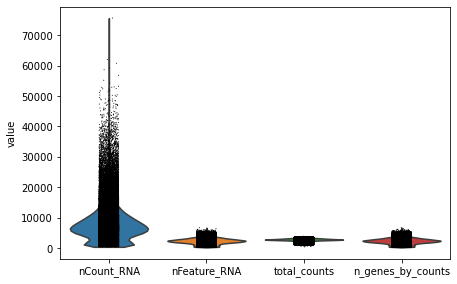

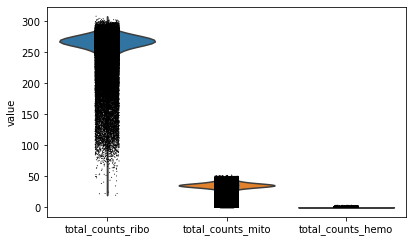

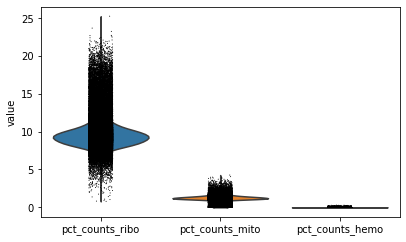

In [9]:
sc.pl.violin(adata, keys = ['nCount_RNA','nFeature_RNA', 'total_counts', 'n_genes_by_counts'])
sc.pl.violin(adata, keys = ['total_counts_ribo','total_counts_mito', 'total_counts_hemo'])
sc.pl.violin(adata, keys = ['pct_counts_ribo','pct_counts_mito', 'pct_counts_hemo'])

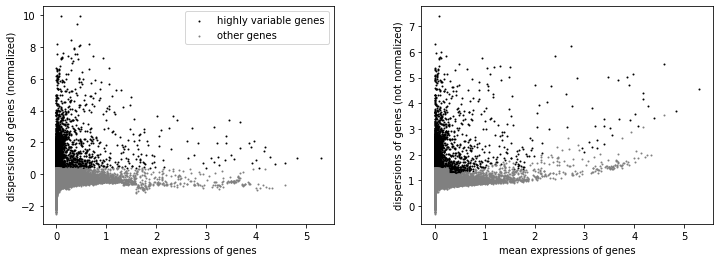

In [10]:
sc.pp.highly_variable_genes(adata, n_top_genes = 4000)
sc.pl.highly_variable_genes(adata)

In [11]:
sc.pp.scale(adata, zero_center = False)

In [12]:
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes = g2m_genes)

In [13]:
sc.pp.pca(adata)
#sc.pp.neighbors(adata)
bbknn.bbknn(adata, batch_key='orig.ident')
sc.tl.umap(adata)

In [14]:
sc.tl.leiden(adata, resolution = 0.3)

In [15]:
adata

AnnData object with n_obs × n_vars = 116180 × 17703
    obs: 'Immune21', 'Infundibulum1', 'RBC1', 'RNA_snn_res.0.1', 'integrated_snn_res.0.1', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'percent.mt', 'seurat_clusters', 'geno', 'induction', 'injury', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_hemo', 'log1p_total_counts_hemo', 'pct_counts_hemo', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'ribo', 'mito', 'hemo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_p

... storing 'phase' as categorical


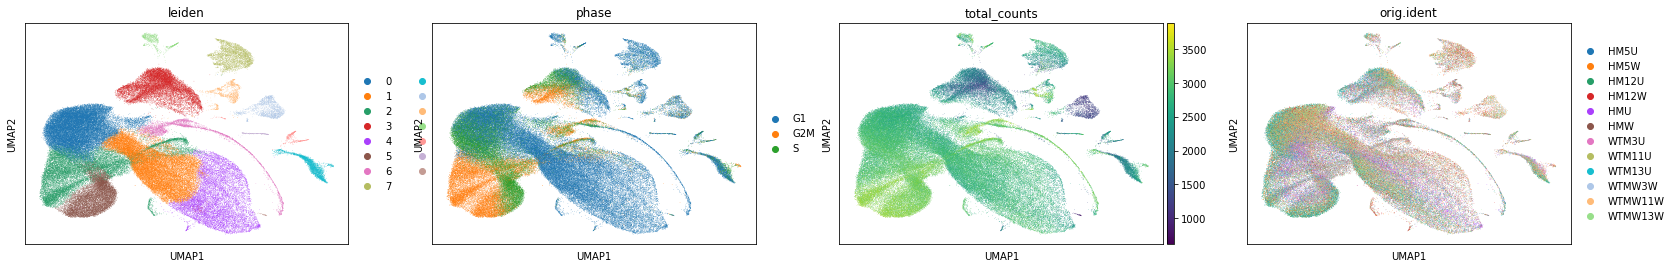

In [16]:
sc.pl.umap(adata, color = ['leiden', 'phase', 'total_counts', 'orig.ident'])

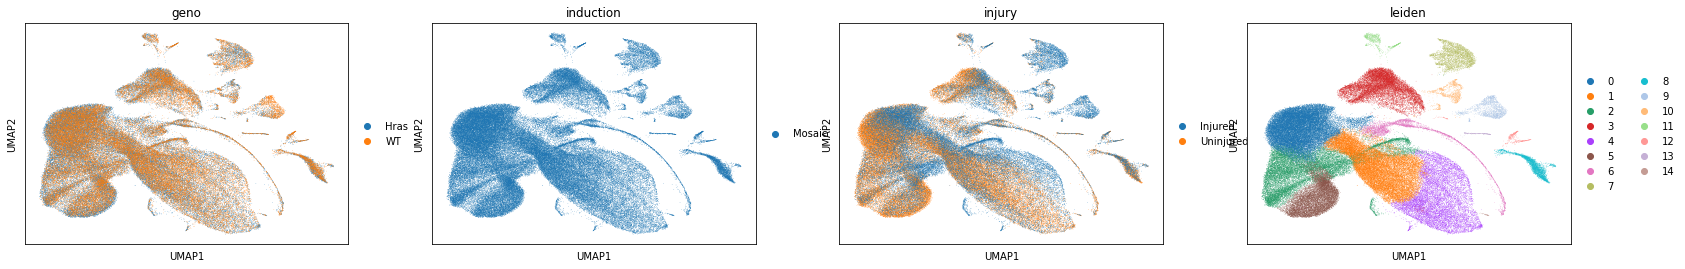

In [17]:
sc.pl.umap(adata, color = ['geno', 'induction', 'injury', 'leiden'])

# Remove the low-count cluster

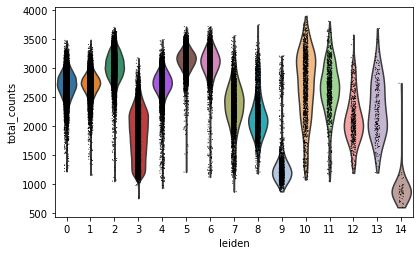

In [32]:
sc.pl.violin(adata, keys = 'total_counts', groupby = 'leiden')

ax = axes[ix // ncols, ix % ncols]


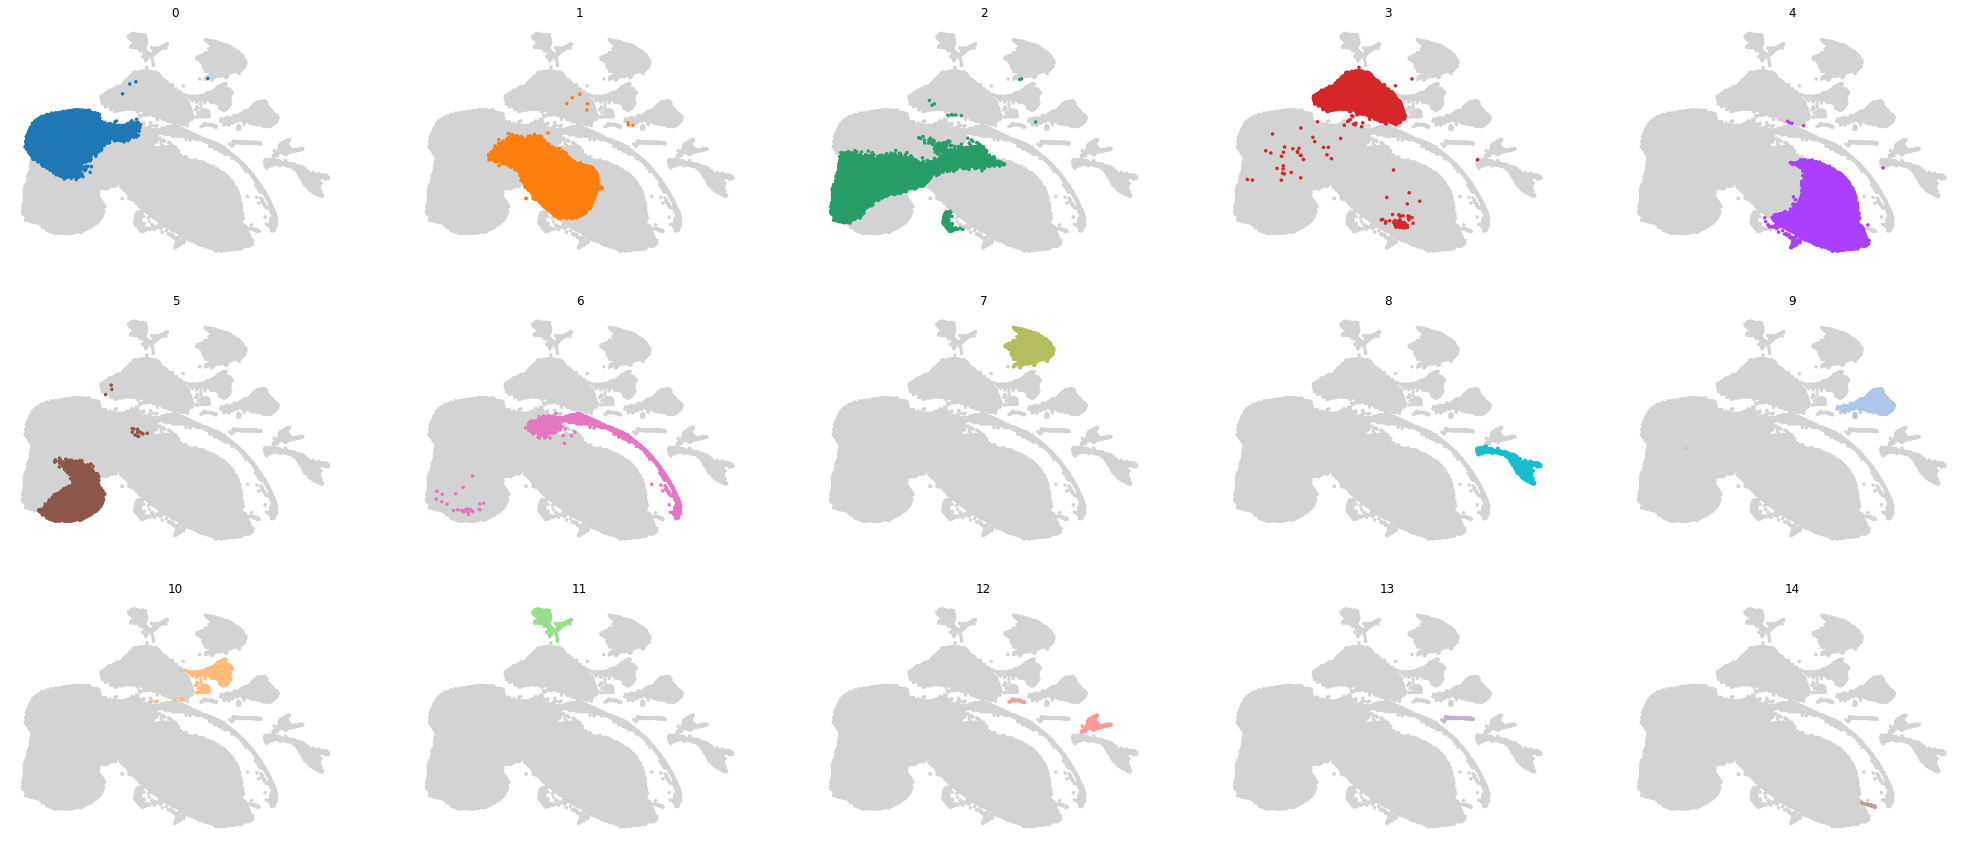

In [33]:
groups = adata.obs['leiden'].cat.categories
ncols = 5
fig, axes = initialize_subplots(len(groups), ncols = ncols)

for ix, g in enumerate(sorted(groups, key = lambda x: int(x))):
    ax = get_ax(axes, ix, ncols)
    sc.pl.umap(adata, color = 'leiden', ax = ax, show = False, frameon = False, groups = [g], legend_loc = 'on_data', title = g, s = 50)

In [37]:
adata = adata[adata.obs['leiden']!='3'].copy()

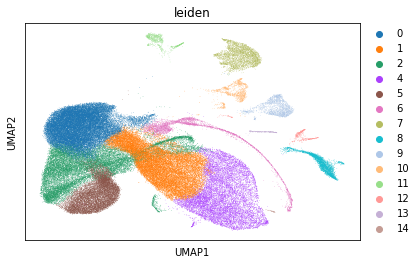

In [38]:
sc.pl.umap(adata, color = 'leiden')

In [39]:
sc.pp.pca(adata)
#sc.pp.neighbors(adata)
bbknn.bbknn(adata, batch_key='orig.ident')
sc.tl.umap(adata)

In [40]:
sc.tl.leiden(adata, resolution = 0.3)

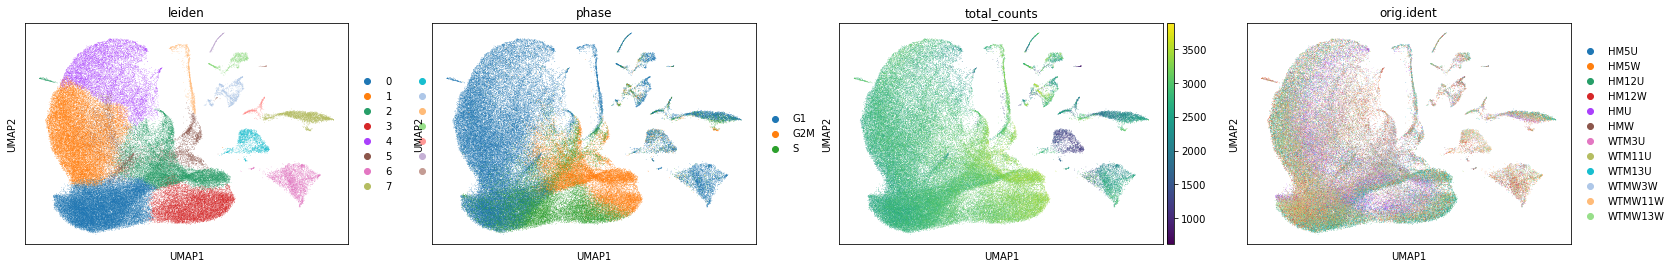

In [41]:
sc.pl.umap(adata, color = ['leiden', 'phase', 'total_counts', 'orig.ident'])

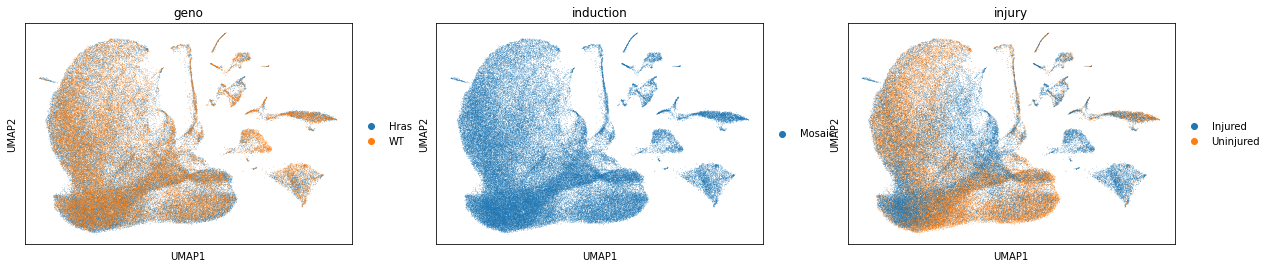

In [42]:
sc.pl.umap(adata, color = ['geno', 'induction', 'injury'])

## Save 2

In [43]:
path = '/mnt/c/Users/User/Desktop/To Be Deleted/Delete me!/Sara_seq_raw_loom'
adata.write_h5ad(os.path.join(path, 'Combined_datasets_filtered.h5ad'))

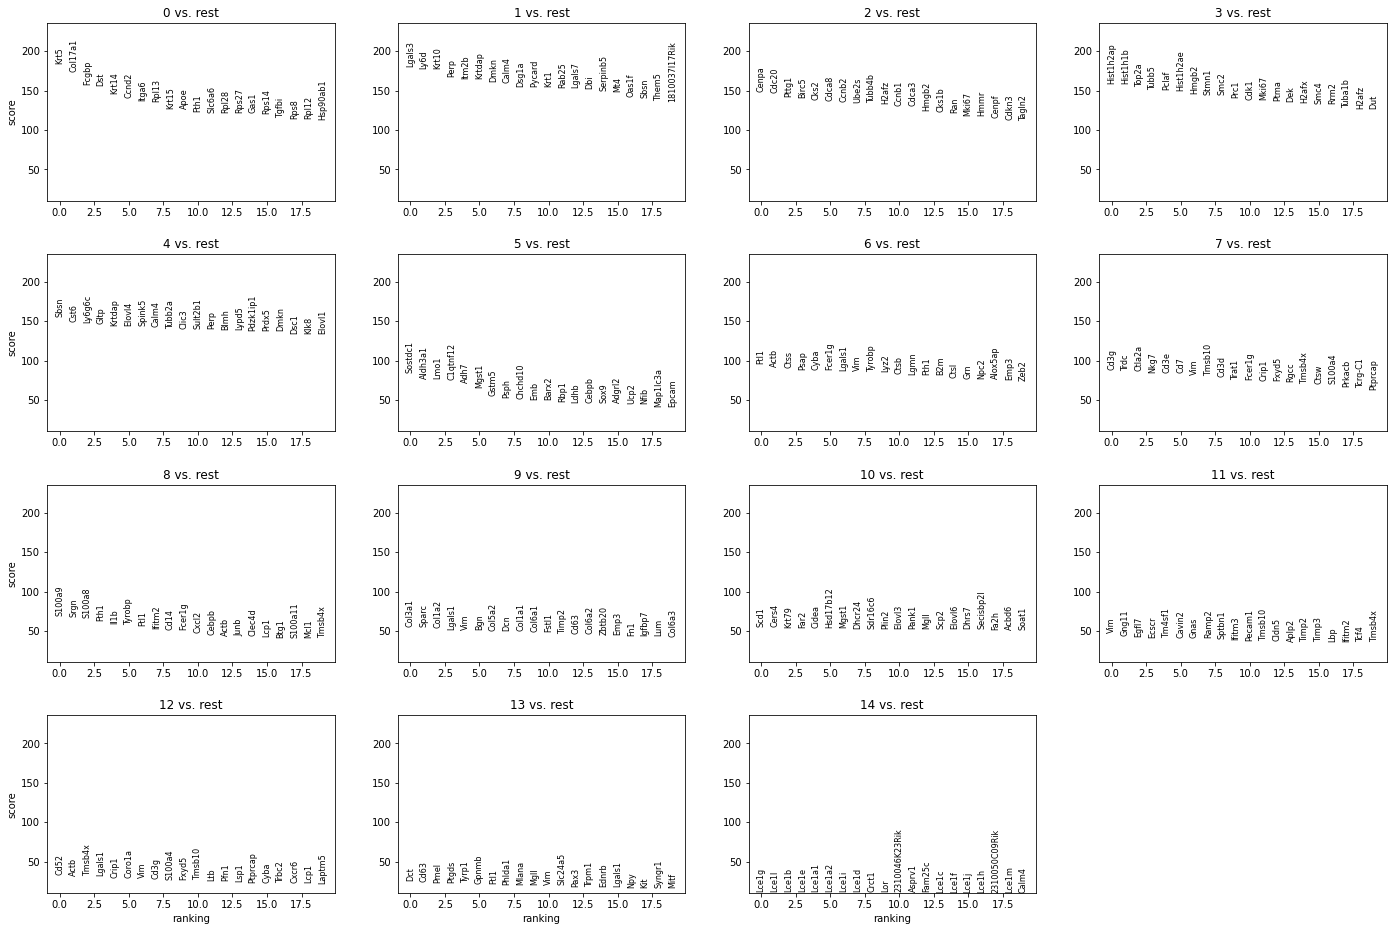

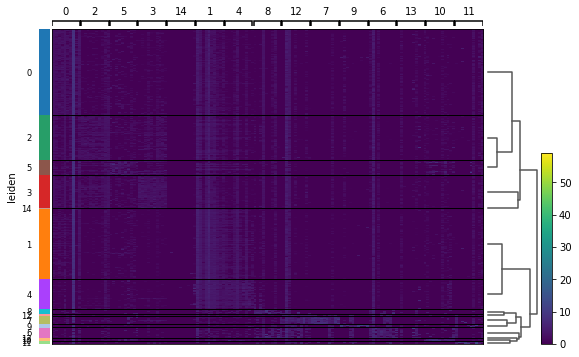

In [44]:
sc.tl.rank_genes_groups(adata, groupby = 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata)
sc.pl.rank_genes_groups_heatmap(adata) 

In [45]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

0       1       2          3       4         5       6       7  \
0     Krt5  Lgals3   Cenpa  Hist1h2ap    Sbsn   Sostdc1    Ftl1    Cd3g   
1  Col17a1    Ly6d   Cdc20   Hist1h1b    Cst6   Aldh3a1    Actb    Trdc   
2    Fcgbp   Krt10   Pttg1      Top2a  Ly6g6c      Lmo1    Ctss  Ctla2a   
3      Dst    Perp   Birc5      Tubb5    Gltp  C1qtnf12    Psap    Nkg7   
4    Krt14   Itm2b    Cks2      Pclaf  Krtdap      Adh7    Cyba    Cd3e   
5    Ccnd2  Krtdap   Cdca8  Hist1h2ae  Elovl4     Mgst1  Fcer1g     Cd7   
6    Itga6    Dmkn   Ccnb2      Hmgb2  Spink5     Gstm5  Lgals1     Vim   
7    Rpl13   Calm4   Ube2s      Stmn1   Calm4      Psph     Vim  Tmsb10   
8    Krt15   Dsg1a  Tubb4b       Smc2  Tubb2a   Chchd10  Tyrobp    Cd3d   
9     Apoe  Pycard   H2afz       Prc1   Clic3       Emb    Lyz2   Trat1   

        8       9        10      11      12      13      14  
0  S100a9  Col3a1      Scd1     Vim    Cd52     Dct   Lce1g  
1    Srgn   Sparc     Cers4   Gng11    Actb    Cd63   Lce1l  
2  S100a8  Col1a2     Krt79   Egfl7  Tmsb4x    Pmel   Lce1b  
3    Fth1  Lgals1      Far2   Ecscr  Lgals1   Ptgds   Lce1e  
4    Il1b     Vim     Cidea  Tm4sf1   Crip1   Tyrp1  Lce1a1  
5  Tyrobp     Bgn  Hsd17b12  Cavin2  Coro1a   Gpnmb  Lce1a2  
6    Ftl1  Col5a2     Mgst1    Gnas     Vim    Ftl1   Lce1i  
7  Ifitm2     Dcn    Dhcr24   Ramp2    Cd3g  Phlda1   Lce1d  
8    Cd14  Col1a1   Sdr16c6  Sptbn1  S100a4   Mlana   Crct1  
9  Fcer1g  Col6a1     Plin2  Ifitm3   Fxyd5    Mgll     Lor

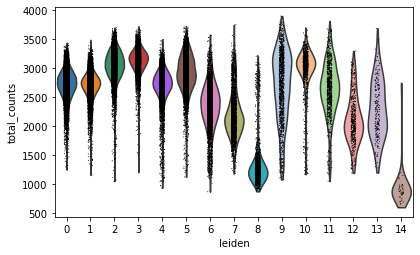

In [46]:
sc.pl.violin(adata, keys = 'total_counts', groupby = 'leiden')

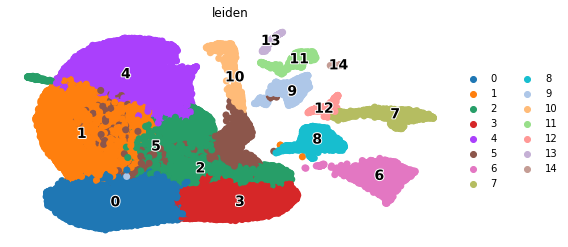

In [47]:
plot_umap_with_legends(adata)

In [48]:
annotations = {'0': 'KC',
               '1': 'KC',
               '2': 'KC',
               '3': 'KC',
               '4': 'KC',
               '5': 'SG',
               '6': 'IMM',
               '7': 'IMM',
               '8': 'IMM',
               '9': 'FIB',
               '10': 'SG',
               '11': 'ENDO',
               '12': 'IMM',
               '13': 'MEL',
               '14': 'KC'}

## Continue

In [49]:
adata.obs['leiden_named'] = adata.obs['leiden'].map(annotations)

... storing 'leiden_named' as categorical


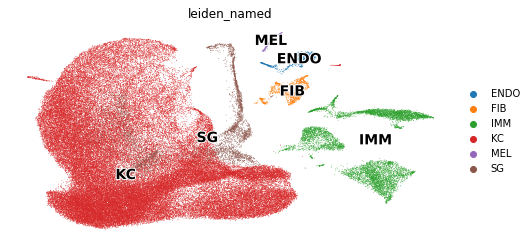

In [50]:
plot_umap_with_legends(adata, color = 'leiden_named', s = 2)

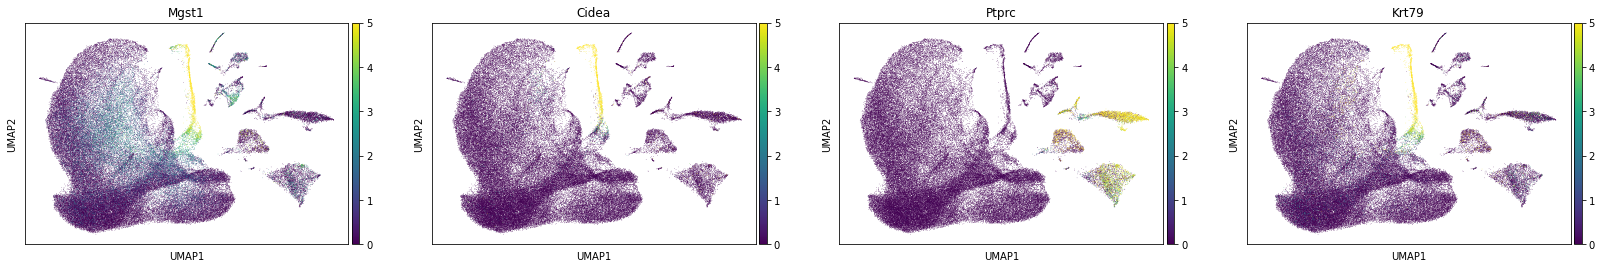

In [51]:
sc.pl.umap(adata, color = ['Mgst1','Cidea','Ptprc', 'Krt79'], vmax = 5)

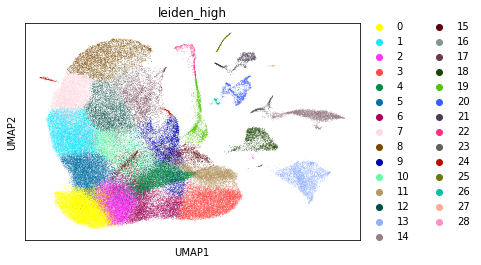

In [52]:
sc.tl.leiden(adata, resolution = 1.5, key_added='leiden_high')
sc.pl.umap(adata, color = 'leiden_high')

In [ ]:
annotations = {'0': 'KC',
               '1': 'KC',
               '2': 'KC',
               '3': 'KC',
               '4': 'KC',
               '5': 'KC',
               '6': 'KC',
               '7': 'KC',
               '8': 'KC',
               '9': 'KC',
               '10': 'IMM',
               '11': 'KC',
               '12': 'KC',
               '13': 'KC',
               '14': 'KC',
               '15': 'KC',
               '16': 'KC',
               '17': 'IMM',
               '18': 'KC',
               '19': 'IMM',
               '20': 'SG',
               '21': 'SG',
               '22': 'FIB',
               '23': 'KC',
               '24': 'EC',
               '25': 'IMM',
               '26': 'MEL',
               '27': 'KC',
               '28': 'EC',
               '29': 'FIB',
               '30': 'IMM',
               '31': 'IMM',
               '32': 'KC'}

In [86]:
adata.obs['leiden_named'] = adata.obs['leiden_high'].map(annotations)

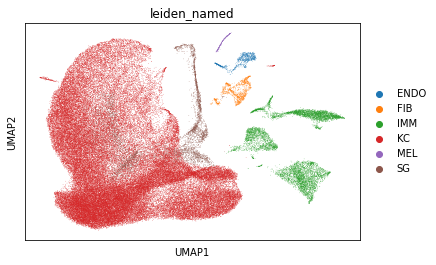

In [53]:
sc.pl.umap(adata, color = 'leiden_named')

ax = axes[ix // ncols, ix % ncols]


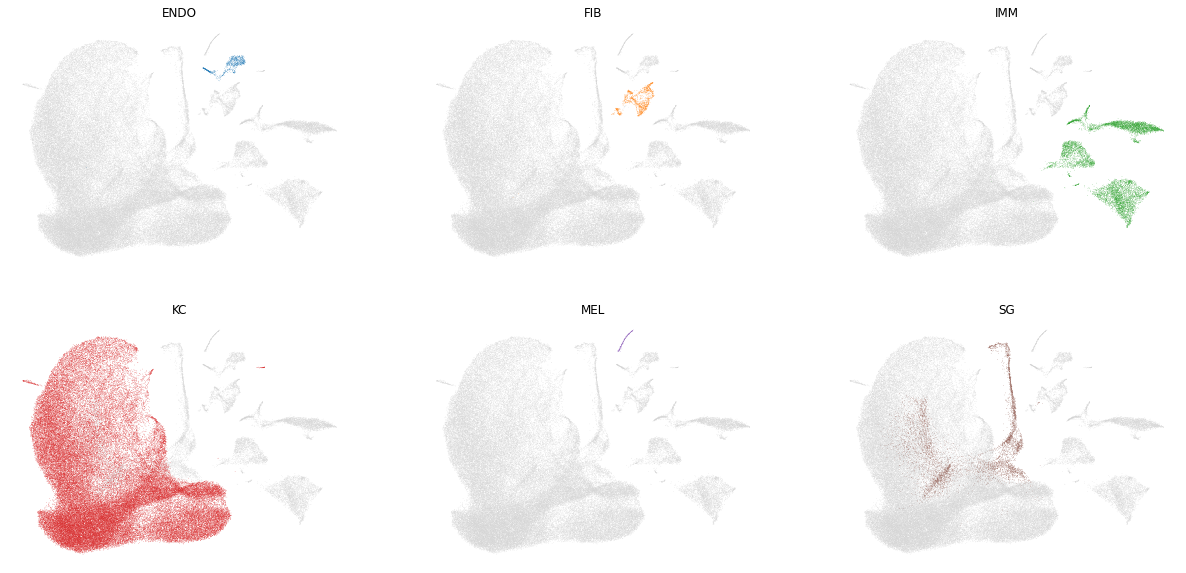

In [54]:
cluster = 'leiden_named'
groups = adata.obs[cluster].cat.categories
ncols = 3
fig, axes = initialize_subplots(len(groups), ncols = ncols)

for ix, g in enumerate(sorted(groups)):
    ax = get_ax(axes, ix, ncols)
    sc.pl.umap(adata, color = cluster, ax = ax, show = False, frameon = False, groups = [g], legend_loc = 'on_data', title = g, s = 1)

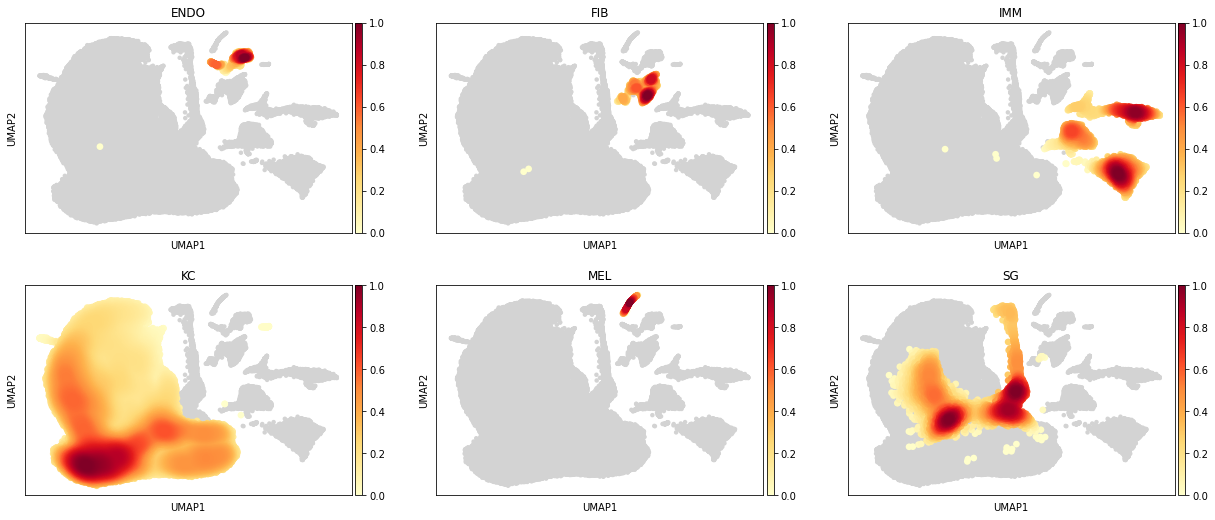

In [56]:
sc.pl.embedding_density(adata, key = 'umap_density_leiden_named', ncols = 3)

ax = axes[ix // ncols, ix % ncols]


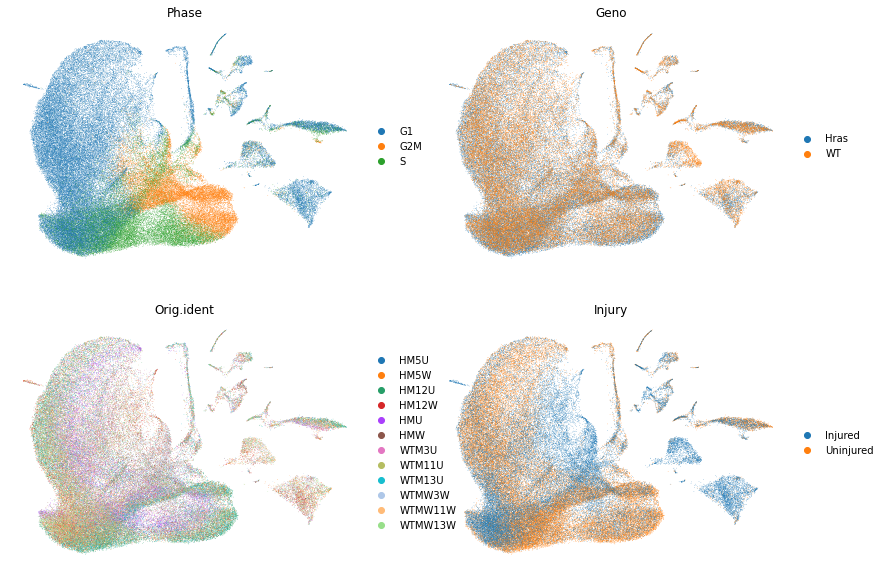

In [60]:
colors = ['phase', 'geno', 'orig.ident', 'injury']

ncols = 2
fig, axes = initialize_subplots(len(colors), ncols = ncols)
for ix, color in enumerate(colors):
    ax = get_ax(axes, ix, ncols)
    sc.pl.umap(adata, color = color, frameon = False, show = False, ax = ax, title = color.capitalize())
    
#fig.savefig(os.path.join(path, 'Figs', 'Combined_All-cells_Types.pdf'), bbox_inches = 'tight')
#fig.savefig(os.path.join(path, 'Figs', 'Combined_All-cells_Types.png'), bbox_inches = 'tight')

In [69]:
adata.obs['orig.ident'] = adata.obs['orig.ident'].cat.reorder_categories(['HMU', 'HM5U', 'HM12U', 'HMW', 'HM5W', 'HM12W', 'WTM3U', 'WTM11U',
       'WTM13U', 'WTMW3W', 'WTMW11W', 'WTMW13W'])

In [91]:
colors = sbn.color_palette(palette = 'Blues_r', n_colors = 3)
colors.extend(sbn.color_palette(palette = 'Oranges_r', n_colors = 3))
colors.extend(sbn.color_palette(palette = 'Greens_r', n_colors = 3))
colors.extend(sbn.color_palette(palette = 'Purples_r', n_colors = 3))
adata.uns['orig.ident_colors'] = [mpl.colors.rgb2hex(c) for c in colors]

ax = axes[ix]


[None, None]

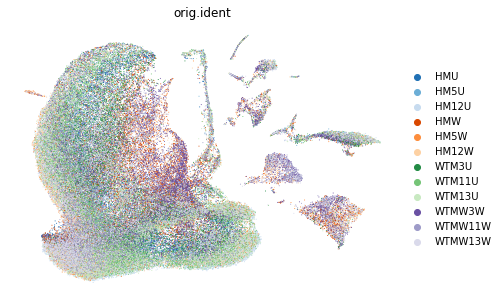

In [172]:
fig, ax = initialize_subplots(1, 1)
sc.pl.umap(adata, color = 'orig.ident', ax = ax, show = False, frameon = False, s = 4)
[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_Identity.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

ax = axes[ix]


[None, None]

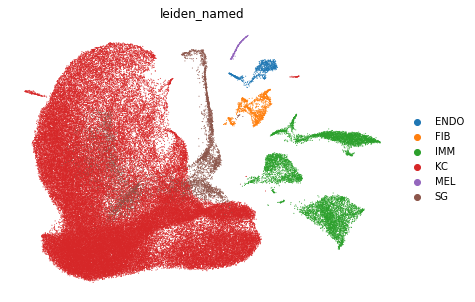

In [171]:
fig, ax = initialize_subplots(1, 1)
sc.pl.umap(adata, color = 'leiden_named', ax = ax, show = False, frameon = False, s = 4)
[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_Clusters.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

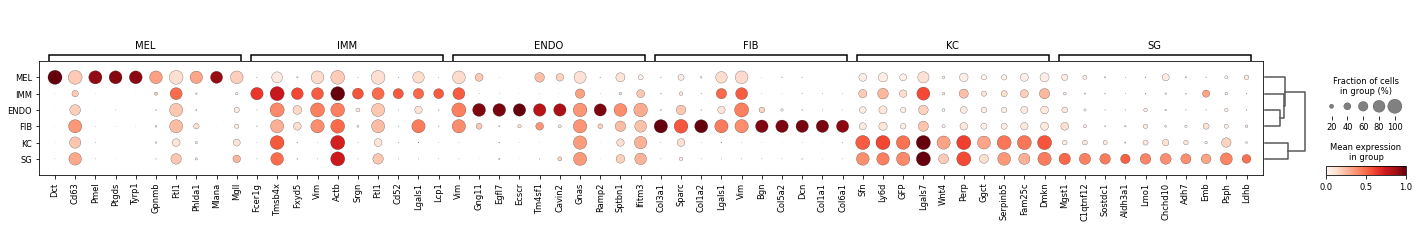

In [110]:
#Each expression level is standardixed within the group - highest level = 1
sc.pl.rank_genes_groups_dotplot(adata, groupby = 'leiden_named', standard_scale = 'group')

ax = axes[ix // ncols, ix % ncols]


[None, None]

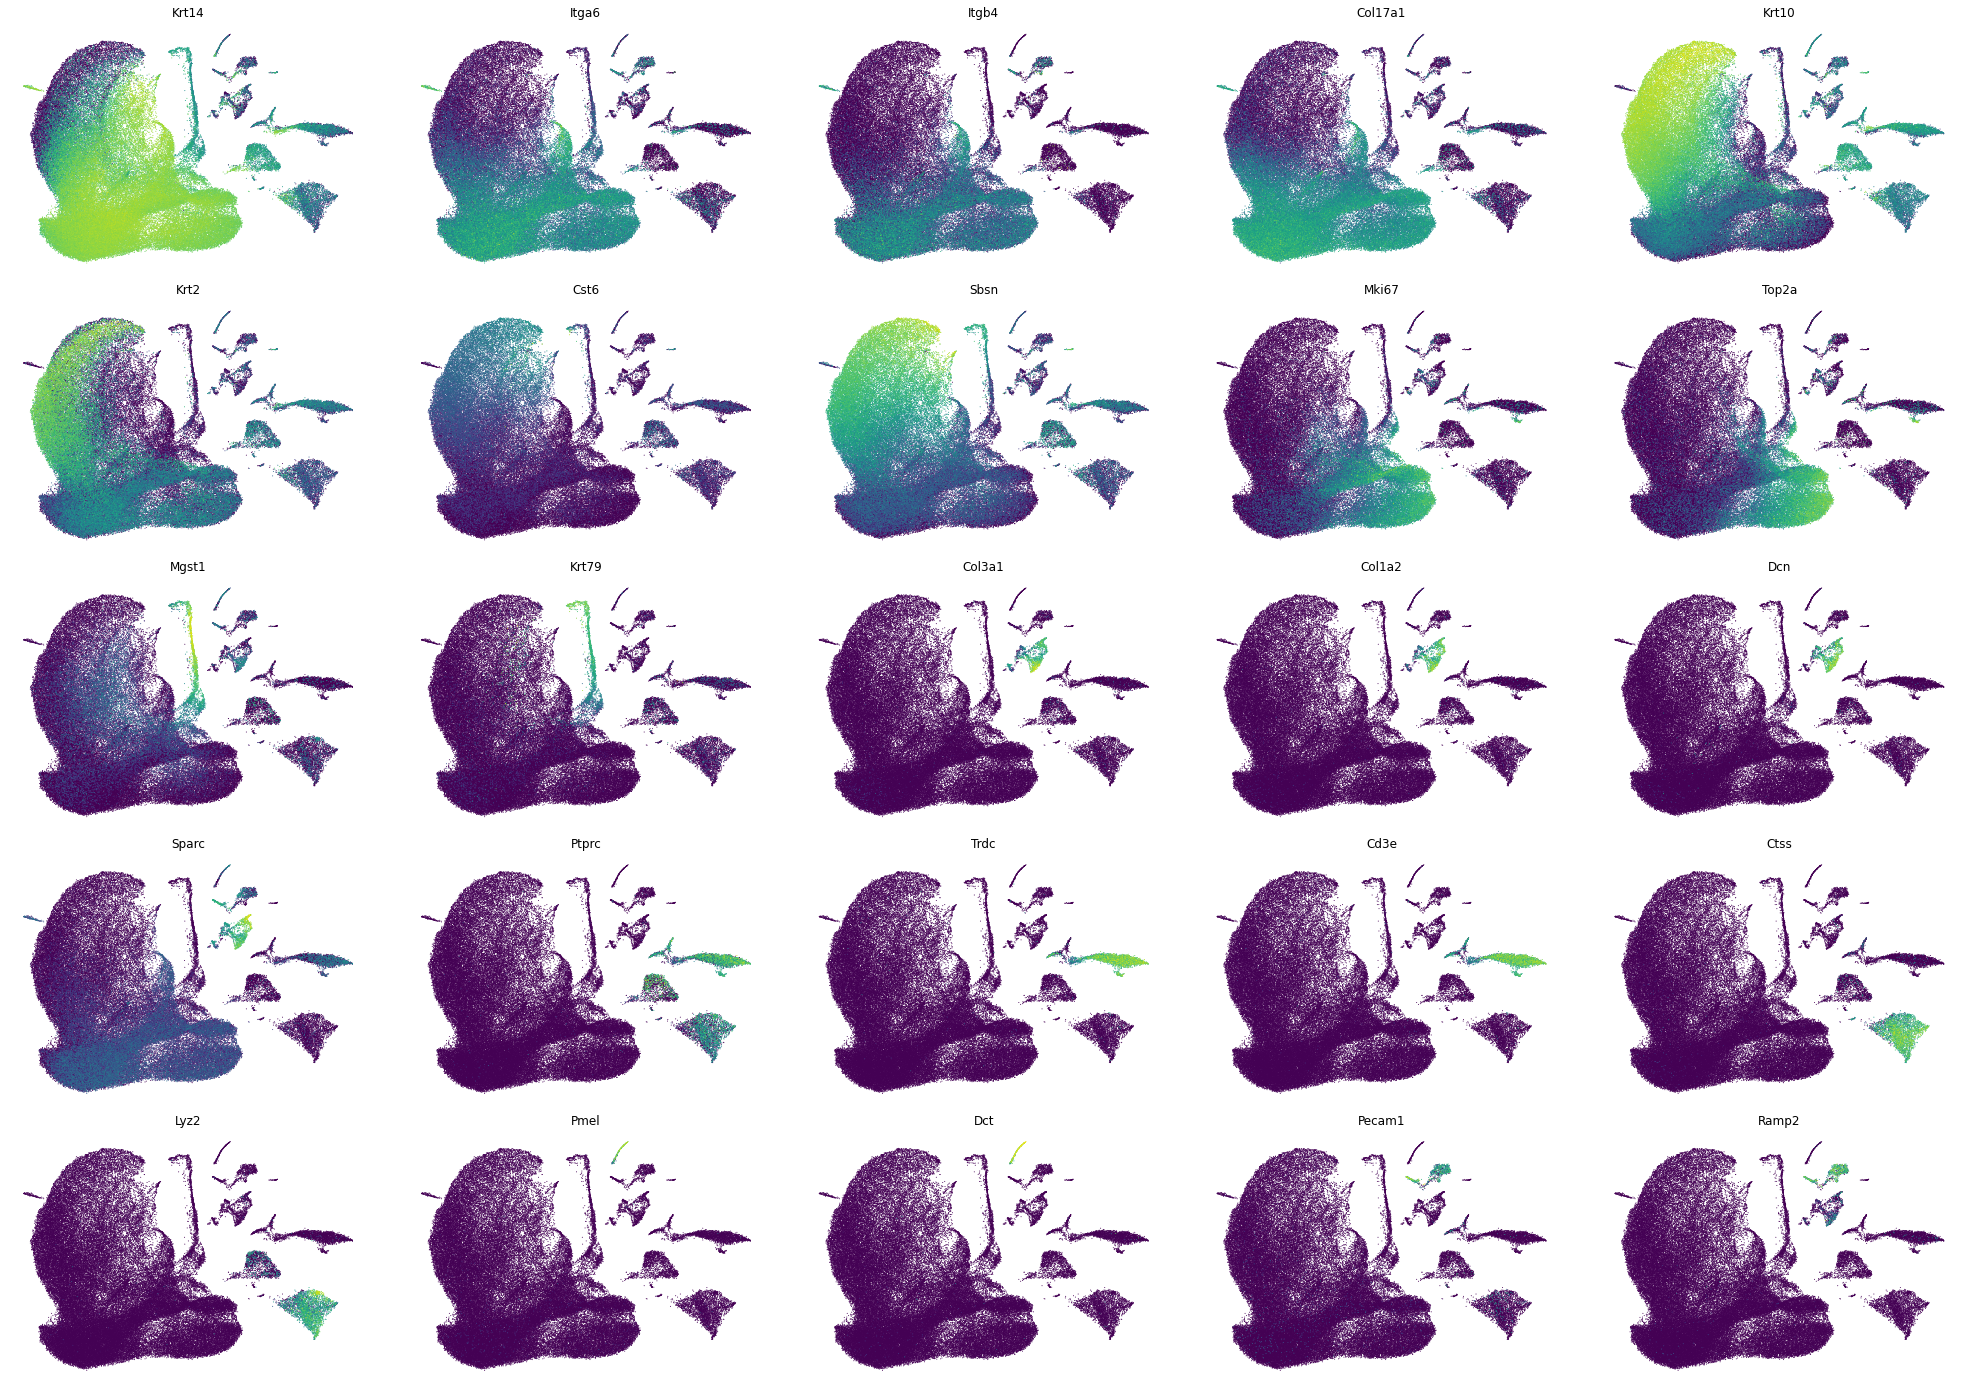

In [184]:
genes = ['Krt14', 'Itga6', 'Itgb4', 'Col17a1', 'Krt10', 'Krt2','Cst6', 'Sbsn', 'Mki67','Top2a', 'Mgst1','Krt79','Col3a1', 'Col1a2','Dcn','Sparc','Ptprc','Trdc','Cd3e','Ctss','Lyz2','Pmel','Dct','Pecam1','Ramp2']
ncols = 5
fig, axes = initialize_subplots(len(genes), ncols = ncols, gridspec_kw = {'wspace':0.1, 'hspace':0.1})
for ix, g in enumerate(genes):
    ax = get_ax(axes, ix, ncols)
    sc.pl.umap(adata, color = g, ax = ax, show = False, frameon = False, s = 4)
    ax.collections[0].colorbar.remove()
    
[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_UMAP_markers.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

ax = axes[ix // ncols, ix % ncols]


[None, None]

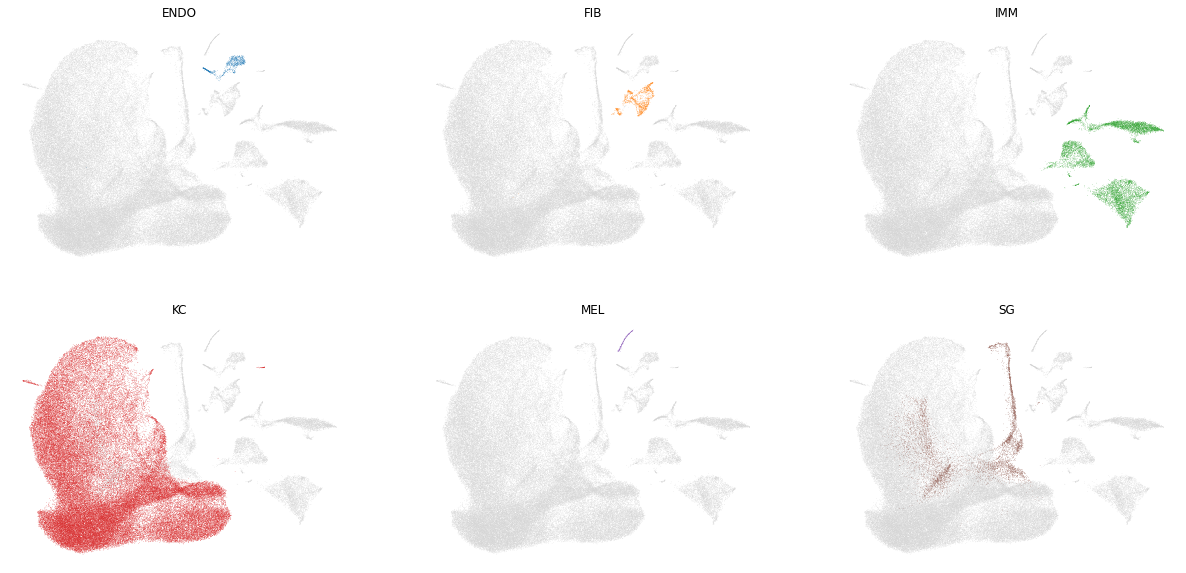

In [185]:
cluster = 'leiden_named'
groups = adata.obs[cluster].cat.categories
ncols = 3
fig, axes = initialize_subplots(len(groups), ncols = ncols)

for ix, g in enumerate(sorted(groups)):
    ax = get_ax(axes, ix, ncols)
    sc.pl.umap(adata, color = cluster, ax = ax, show = False, frameon = False, groups = [g], legend_loc = 'on_data', title = g, s = 1)
    
[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_Clusters_separated.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

# Save annotated data

In [20]:
path = '/mnt/e/IMPORTANT-Backup-Sequencing-Projects/2021-Greco-Sara-Nur-Help/Rebuttal_2022_Analysis'
adata = sc.read_h5ad(os.path.join(path, 'Combined_datasets_filtered_annotated.h5ad'))

In [21]:
adata

AnnData object with n_obs × n_vars = 104594 × 17703
    obs: 'Immune21', 'Infundibulum1', 'RBC1', 'RNA_snn_res.0.1', 'integrated_snn_res.0.1', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'percent.mt', 'seurat_clusters', 'geno', 'induction', 'injury', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_hemo', 'log1p_total_counts_hemo', 'pct_counts_hemo', 'S_score', 'G2M_score', 'phase', 'leiden', 'leiden_named', 'leiden_high', 'umap_density_leiden_named'
    var: 'ribo', 'mito', 'hemo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns

# Plots for figures

## Fig s4b

ax = axes[ix]


<AxesSubplot:xlabel='UMAP1', ylabel='UMAP2'>

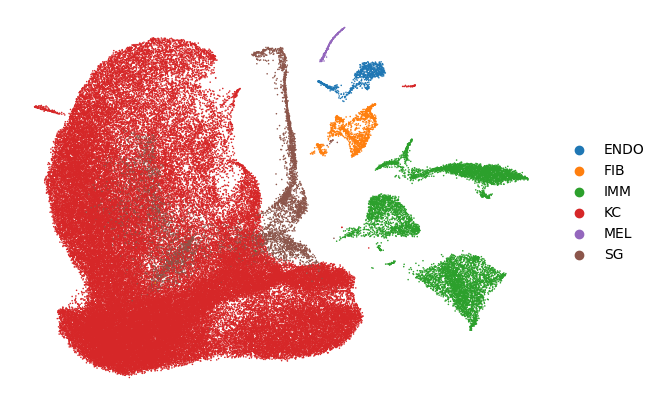

In [12]:
fig, ax = initialize_subplots(1, 1)
sc.pl.umap(adata, color = 'leiden_named', ax = ax, show = False, frameon = False, s = 5, title = '')
#[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_Clusters.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

In [22]:
genes = {'KC': ['Krt14', 'Krt5', 'Krt15', 'Itga6', 'Itgb4', 'Col17a1', 'Krt10', 'Krt1', 'Krt2', 'Cst6','Sbsn'],
         'SG': ['Mgst1','Krt79','Defb6', 'Cidea'],
         'FIB': ['Col3a1','Col1a2','Dcn','Sparc'],
         'IMM': ['Ptprc', 'Trdc', 'Cd3g','Cd3e','Ctss', 'Lyz2', 'Nkg7'],
         'ENDO': ['Pecam1','Cavin2','Ramp2','Egfl7'],
         'MEL': ['Pmel','Tyr','Mlana','Dct']}

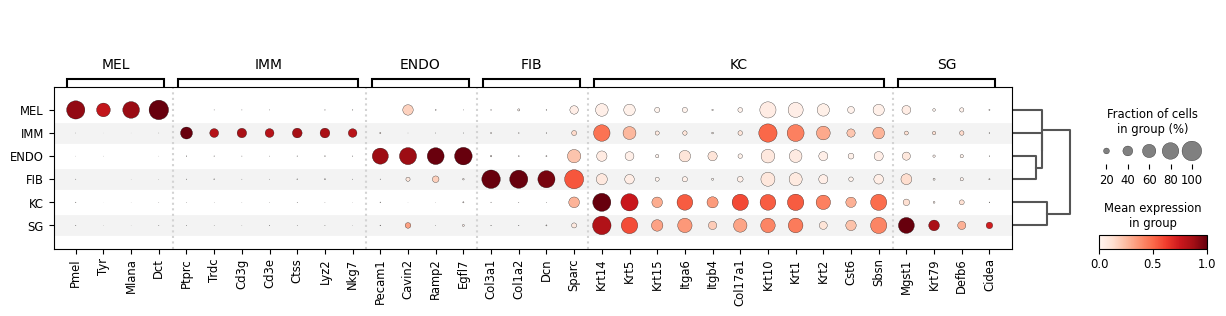

In [23]:
fig = sc.pl.dotplot(adata, groupby = 'leiden_named', var_names = genes, standard_scale = 'group', dendrogram=True, show = True, return_fig=True)

ax = fig.get_axes()
cats = adata.uns['dendrogram_leiden_named']['categories_ordered']
x = 0
for y, c in enumerate(cats):
    x+=len(genes[c])
    if y != len(cats)-1:
        fig.ax_dict['mainplot_ax'].axvline(x, ls = ':', c = 'lightgray')
    if y%2==1:
        fig.ax_dict['mainplot_ax'].axhline(y+0.5, c = 'lightgray', zorder = -10, linewidth=15, alpha = 0.25)
fig = plt.gcf()
#[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_Dotplot_markers.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

## Reload raw loom file

In [14]:
path = '/mnt/e/IMPORTANT-Backup-Sequencing-Projects/2021-Greco-Sara-Nur-Help/Rebuttal_2022_Analysis'
adata = sc.read_loom(os.path.join(path, 'Combined_datasets.loom'), validate = False)

In [15]:
adata.obs['orig.ident'].value_counts().sort_index()

HM12U       9864
HM12W      10281
HM5U        9650
HM5W        9590
HMU        11437
HMW         8922
WTM11U     11856
WTM13U      9916
WTM3U       8416
WTMW11W     9181
WTMW13W     8747
WTMW3W      8320
Name: orig.ident, dtype: int64

# plots

In [16]:
sample = {'HMU': 'HMU',
          'HM5U': 'HMU', 
          'HM12U': 'HMU',
          'HM5W': 'HMW',
          'HM12W': 'HMW', 
          'HMW': 'HMW', 
          'WTM3U': 'WTMU', 
          'WTM11U': 'WTMU', 
          'WTM13U': 'WTMU',
          'WTMW3W': 'WTMW', 
          'WTMW11W': 'WTMW', 
          'WTMW13W': 'WTMW'}
adata.obs['batch'] = adata.obs['orig.ident'].map(sample)

replicate = {'HMU': 'Mouse1',
             'HM5U': 'Mouse2', 
             'HM12U': 'Mouse3',
             'HMW': 'Mouse1',
             'HM5W': 'Mouse2', 
             'HM12W': 'Mouse3', 
             'WTM3U': 'Mouse1', 
             'WTM11U': 'Mouse2', 
             'WTM13U': 'Mouse3',
             'WTMW3W': 'Mouse1', 
             'WTMW11W': 'Mouse2', 
             'WTMW13W': 'Mouse3'}
adata.obs['Replicate'] = adata.obs['orig.ident'].map(replicate)

In [17]:
df = pd.DataFrame(adata.obs.groupby('batch')['Replicate'].value_counts())
df.columns = ['ncells']
df = df.reset_index()
df.pivot(columns = 'batch', index = 'Replicate')

ncells                    
batch        HMU    HMW   WTMU  WTMW
Replicate                           
Mouse1     11437   8922   8416  8320
Mouse2      9650   9590  11856  9181
Mouse3      9864  10281   9916  8747

## Fig S4a

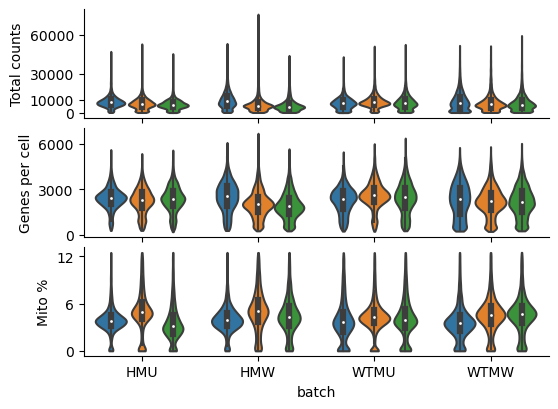

In [19]:
rename = {'nCount_RNA': 'Total counts', 
          'nFeature_RNA': 'Genes per cell', 
          'percent.mt': 'Mito %'}

plots = ['nCount_RNA', 'nFeature_RNA', 'percent.mt']
ncols = 1
fig, axes = initialize_subplots(len(plots), ncols = ncols, figsize_multiplier = (6, 1.5), sharex = True, print_help=False, gridspec_kw = {'hspace': 0.1})

for ix, y in enumerate(plots):
    ax = get_ax(axes, ix, ncols)
    sbn.violinplot(data = adata.obs, x = 'batch', y = y, hue = 'Replicate', inner = 'box', ax = ax, cut = 0)
    handles, labels = ax.get_legend_handles_labels()
    #sbn.stripplot(data = adata.obs, x = 'batch', y = y, hue = 'Replicate', ax = ax, dodge = 0.25, color = 'k', s = 0.3)
    if y == 'nCount_RNA':
        #ax.legend(handles = handles, labels = labels, bbox_to_anchor = (1.4,1), frameon = False)
        ax.legend('', frameon = False)
        ax.set_yticks([0, 10000, 30000, 60000])
    else:
        ax.legend('', frameon = False)
        ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins = 3, min_n_ticks = 2, steps = [1, 3, 6]))
    
    [ax.spines[spine].set_visible(False) for spine in ['top','right']]
    ax.set_ylabel(rename[y])
#[fig.savefig(os.path.join(path, 'Figs', f'Combined_All-cells_QC_boxplot.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]